# Laugh test 2: Storage and transmission in soils
This notebook plots SUMMA simulations for the test case defined in Miller et al. (1998). 

## Expectations
The simulations should reproduce Figure 1 in Miller et al. (1998):

![Figure 1a in Miller et al. (1998)](https://raw.githubusercontent.com/CH-Earth/laughTests/master/lt2_miller1998/img/miller1998_fig1.png?token=ABZLT4QVYAID4GE74I3OUJ27DMWLS)

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  |  See attributes in output .nc file |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | R. Zolfaghari |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

Miller, C. T., Williams, G. A., Kelley, C. T. & Tocci, M. D. (1998), Robust solution of Richard's equation for nonuniform porous media, Water Resour. Res., 34(10), 2599–2610, https://doi.org/10.1029/98WR01673

In [1]:
# modules
from pathlib import Path
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt

In [2]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_sand = "millerSand_output_timestep.nc"
sim_clay = "millerClay_output_timestep.nc"
sim_loam = "millerLoam_output_timestep.nc"

In [3]:
# Specify the time of interest, converted into a timestep index by dividing by time step length
dt = 900 # time step length in [s], this is a setting in the model input files
time_sand = int( (0.18*86400)/dt ) # d * (s/d) / (s/timestep)
time_clay = int( (1.00*86400)/dt ) # int() rounds down to nearest integer
time_loam = int( (2.25*86400)/dt )

In [4]:
# Specify plotting dimensions
midToto = 0

Processing starts here

In [5]:
# Load the data
ds_sand = xr.open_dataset( sim_path / sim_sand ).isel(hru=0, gru=0, time=time_sand).load()
ds_clay = xr.open_dataset( sim_path / sim_clay ).isel(hru=0, gru=0, time=time_clay).load()
ds_loam = xr.open_dataset( sim_path / sim_loam ).isel(hru=0, gru=0, time=time_loam).load()

In [6]:
# Remove missing data layers
ds_sand = ds_sand.where(ds_sand['mLayerDepth'] != -9999, drop=True)
ds_clay = ds_clay.where(ds_clay['mLayerDepth'] != -9999, drop=True)
ds_loam = ds_loam.where(ds_loam['mLayerDepth'] != -9999, drop=True)

In [7]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

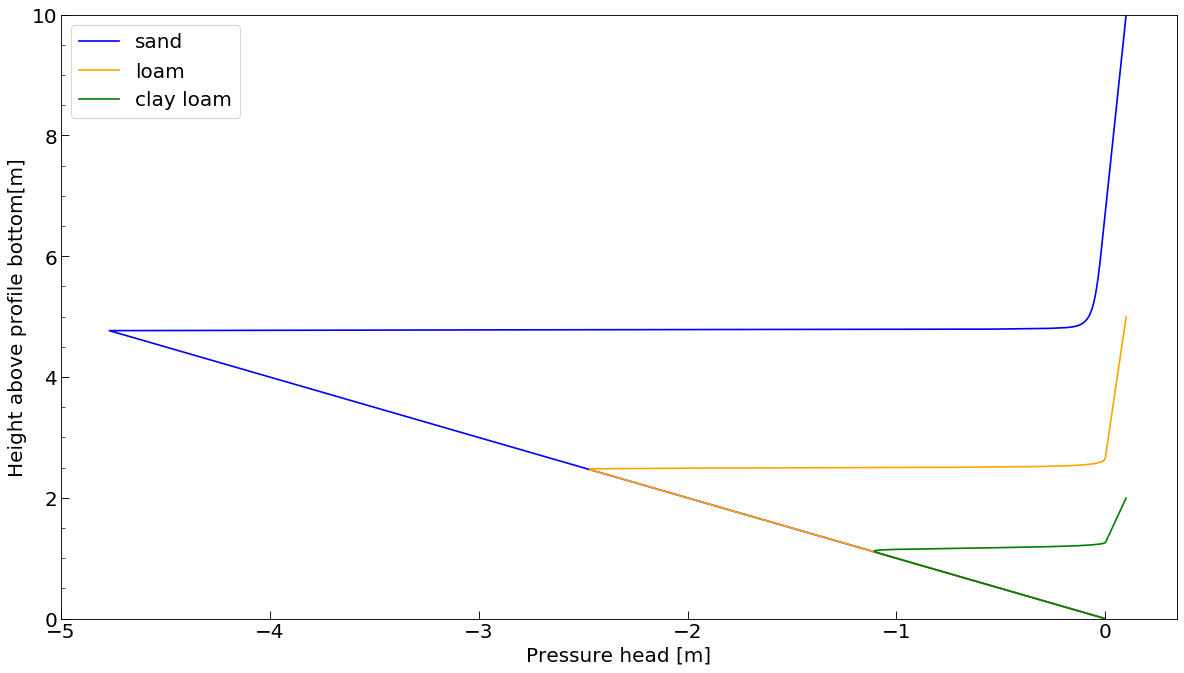

In [8]:
# Open a figure
fig = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k');

# Plot the data
plt.plot(ds_sand['mLayerMatricHead'].isel(midToto=midToto),ds_sand['mLayerHeight'][::-1], \
         marker='', color='blue',   label='sand'); # [::-1] inverts the layer height vector -- see below
plt.plot(ds_loam['mLayerMatricHead'].isel(midToto=midToto),ds_loam['mLayerHeight'][::-1], \
         marker='', color='orange', label='loam');
plt.plot(ds_clay['mLayerMatricHead'].isel(midToto=midToto),ds_clay['mLayerHeight'][::-1], \
         marker='', color='green',  label='clay loam');

# Labels
plt.xlabel('Pressure head [m]'); 
plt.ylabel('Height above profile bottom[m]');
plt.legend();

# Axes
plt.xlim(left=-5)
plt.ylim(0,10)
ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(which='major', length=7, direction='in')
ax.tick_params(which='minor', length=4, direction='in')

# Save the figure
plt.savefig('img/lt2_miller1998.png');



# ds_sand['mLayerHeight'][::-1] 
# -----------------------------
# This reverses SUMMA's mLayerHeight variable, from a depth below surface (with positive values for deeper layers)
# into a height above bottom of the profile (see test case specifications).

# Water balance check

In [3]:
def components_waterBalance(file_name, inMM = 0):
    
    # Open the dataset
    ds = xr.open_dataset( sim_path / sim_name ).isel(hru=0, gru=0).load()
    
    # Find the time step size [s]
    dt = ((ds['time'].isel(time=1) - ds['time'].isel(time=0))/np.timedelta64(1,'s')).round().values
    
    # Find the midToto indices that are not -9999
    # Note, we know there is no snow in this simulation so we can assume that what works for t=0 works for all t
    layerMask = (ds['mLayerDepth'].isel(time=0) != -9999).values 
    
    # Make a storage depth variable: [m] water in the soil column
    storage = (ds['mLayerVolFracWat'].isel(midToto=layerMask) * \
               ds['mLayerDepth'].isel(midToto=layerMask)).sum(dim='midToto') # [-]*[m]
    
    # Storage change vectors
    s_ini = storage.isel(time=slice(0,-1)).values # initial storage on each time step (i.e. final storage on preceding time step)
    s_fin = storage.isel(time=slice(1, None)).values # final storage on each time step
    d_storage = (s_fin - s_ini) # storage change over each time step
    
    # Fluxes
    inflow =  dt * ds['scalarInfiltration'].isel(time=slice(1, None)) 
    outflow = dt * ds['basin__AquiferRecharge'].isel(time=slice(1, None))
    
    if inMM:
        return d_storage*1000, inflow*1000, outflow*1000
    else:
        return d_storage, inflow, outflow

In [4]:
def plot_waterBalance(ax, d_storage, inflow, outflow, title, inMM):
    
    ax.plot(inflow - outflow, label=r'Inflow - Outflow')
    ax.plot(d_storage, linestyle='--', label='$\Delta S$')
    ax.legend()
    ax.set_xlabel('Timestep')
    if inMM:
        titleUnit = 'mm'
    else:
        titleUnit = 'm'
    ax.set_ylabel('['+titleUnit+']')
    ax.set_title(title+'NET WATER BALANCE = {:10.9f} '.format((inflow - outflow - d_storage).sum().values)+titleUnit)
    
    return     

In [5]:
# Specify that we want [mm]
inMM = 1

In [6]:
# IDA results - clay
sim_name = "millerClay_output_timestep.nc"
d_storage_clay, inflow_clay, outflow_clay = components_waterBalance(sim_name, inMM)

In [7]:
# IDA results - loam
sim_name = "millerLoam_output_timestep.nc"
d_storage_loam, inflow_loam, outflow_loam = components_waterBalance(sim_name, inMM)

In [8]:
# IDA results - sand
sim_name = "millerSand_output_timestep.nc"
d_storage_sand, inflow_sand, outflow_sand = components_waterBalance(sim_name, inMM)

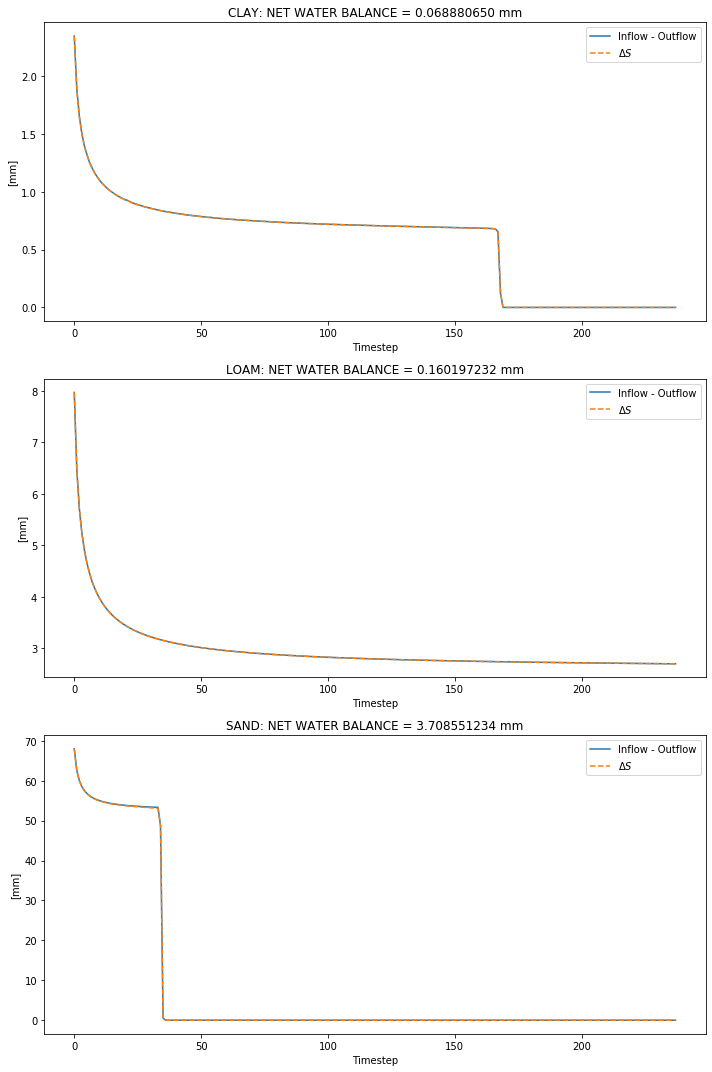

In [9]:
# Plot
fig,ax = plt.subplots(3,1,figsize=(10,15))

plot_waterBalance(ax[0],d_storage_clay,inflow_clay,outflow_clay,'CLAY: ', inMM)
plot_waterBalance(ax[1],d_storage_loam,inflow_loam,outflow_loam,'LOAM: ', inMM)
plot_waterBalance(ax[2],d_storage_sand,inflow_sand,outflow_sand,'SAND: ', inMM)

fig.tight_layout()
plt.savefig('miller_water_balance_comparison.png')

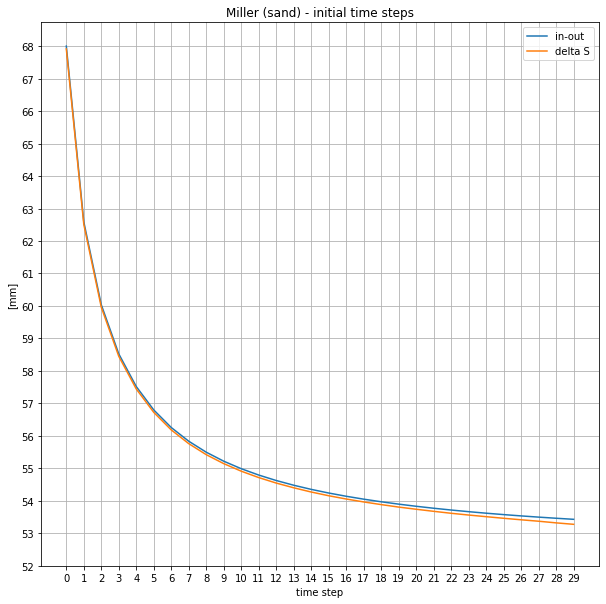

In [17]:
mask = range(0,30)
tick = np.arange(0,30)

plt.figure(figsize=(10,10))

plt.plot(inflow_sand[mask]-outflow_sand[mask], label='in-out')
plt.plot(d_storage_sand[mask], label='delta S')

plt.legend()
plt.xlabel('time step')
plt.ylabel('[mm]')
plt.title('Miller (sand) - initial time steps')

plt.xticks(mask,[str(i) for i in mask]);
plt.yticks(range(52,69),[str(i) for i in range(52,69)]);
plt.grid()

plt.savefig('miller_sand_zoom.png')